# Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/pneumonia dataset FL/train/"))

['NORMAL', 'PNEUMONIA']


In [ ]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

import time
import random
import glob

import cv2
from PIL import Image

# Sample Images

* NORMAL

There are 1266 pictures of NORMAL.


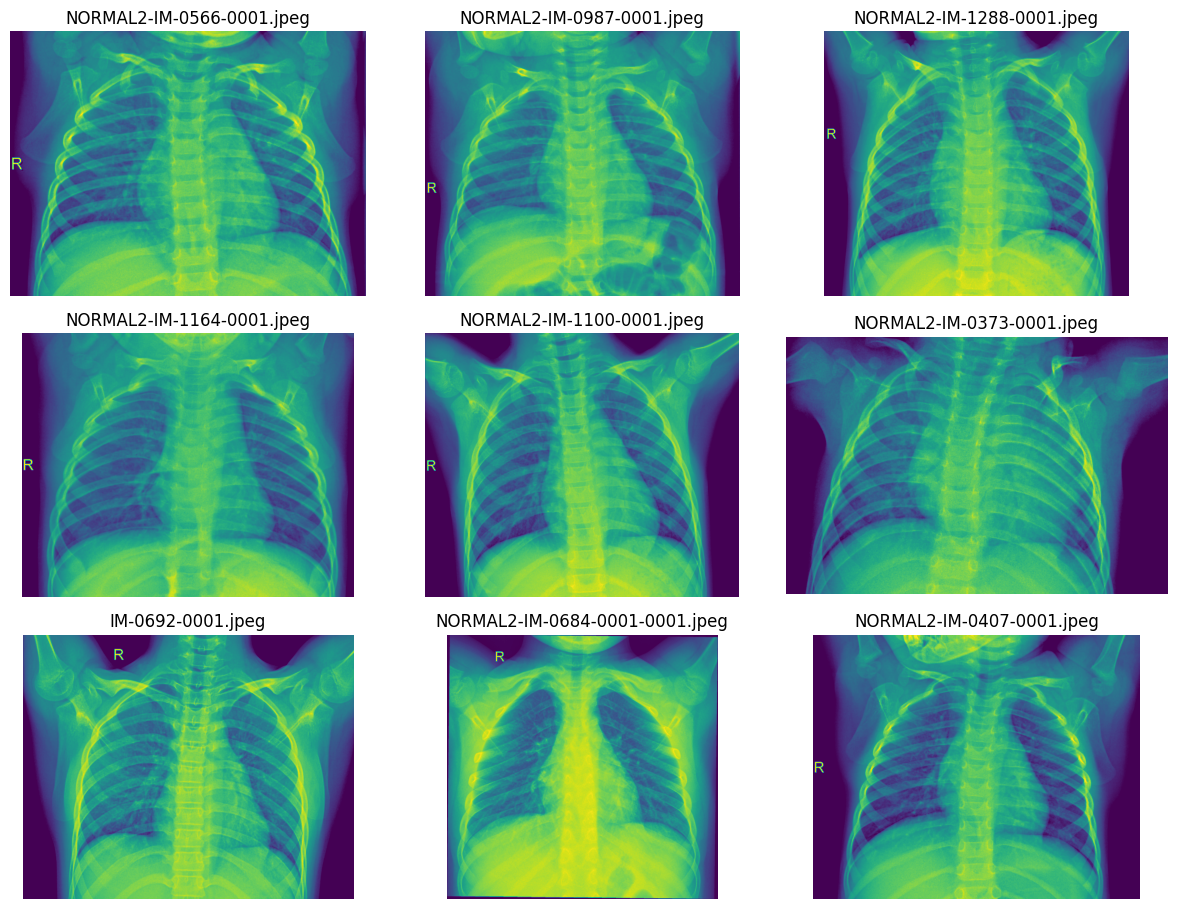

In [ ]:
PATH1 = '/content/drive/MyDrive/pneumonia dataset FL/train/NORMAL/'
images = os.listdir(PATH1)
print(f'There are {len(os.listdir(PATH1))} pictures of NORMAL.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH1)))
    img = plt.imread(PATH1 + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

* PNEUMONIA

There are 3418 pictures of PNEUMONIA.


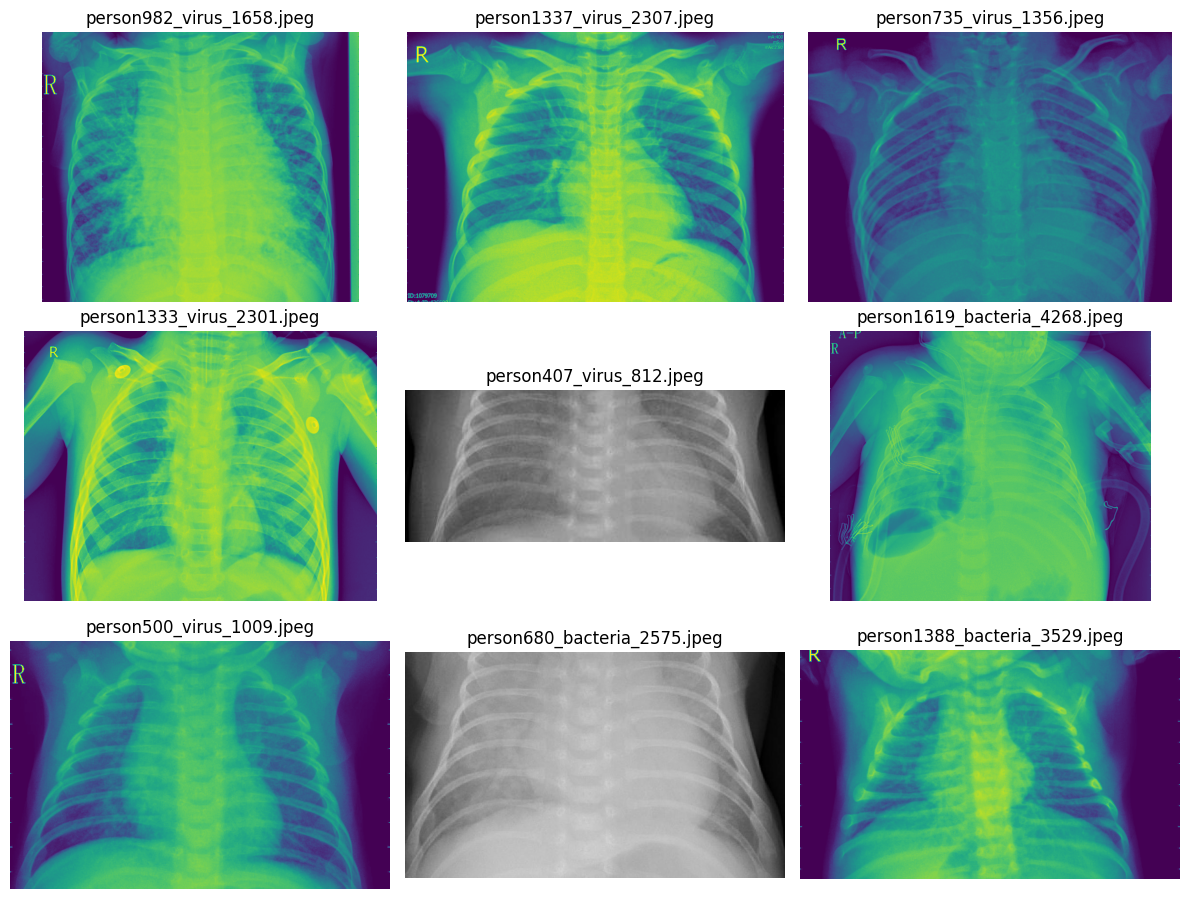

In [ ]:
PATH2 = '/content/drive/MyDrive/pneumonia dataset FL/train/PNEUMONIA/'
images2 = os.listdir(PATH2)
print(f'There are {len(os.listdir(PATH2))} pictures of PNEUMONIA.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH2)))
    img = plt.imread(PATH2 + images2[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images2[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Image Preprocessing

In [ ]:
batch_size = 32
batchSize = 64
imageSize = 64

# 64x64 images!
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('/content/drive/MyDrive/pneumonia dataset FL/train/', transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [ ]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder('/content/drive/MyDrive/pneumonia dataset FL/train/', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 4684
    Root location: /content/drive/MyDrive/pneumonia dataset FL/train/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(64, 64))
               RandomHorizontalFlip(p=0.5)
               RandomApply(
               p=0.2
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
           )
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

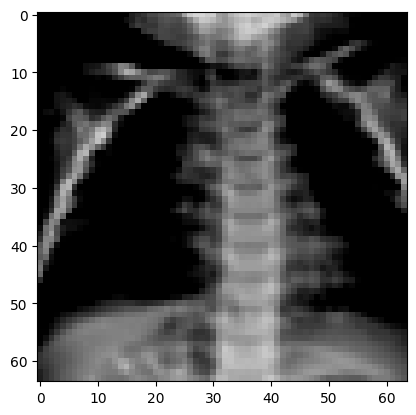

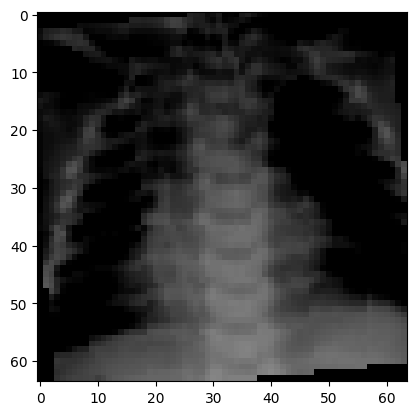

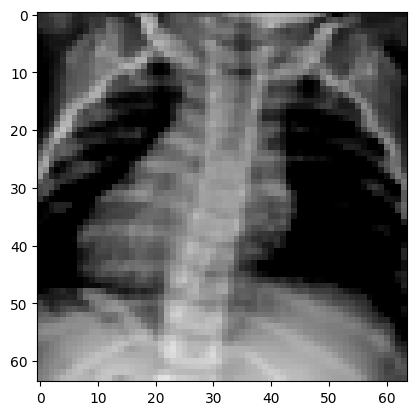

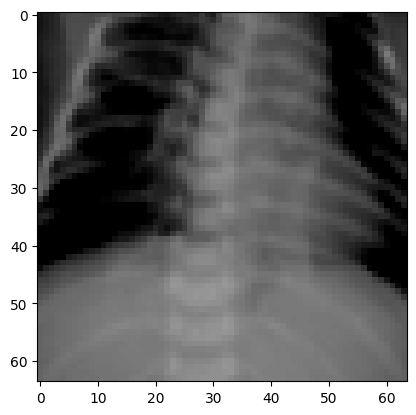

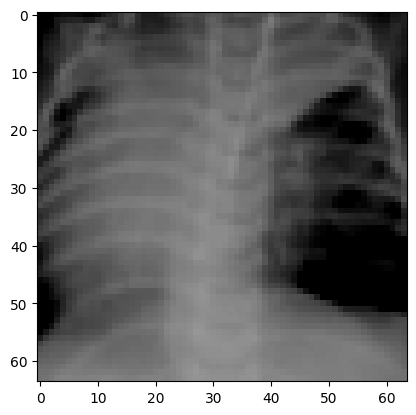

In [ ]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

# Weights

In [ ]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [ ]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )

    def forward(self, input):
        output = self.main(input)
        return output

netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Discriminator

In [ ]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)

netD = D()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()

        self.nz = nz
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)

        return out.view(-1, 1)

# Training

In [ ]:
!mkdir results
!ls

drive  results	sample_data


In [ ]:
EPOCH = 1
LR = 0.0001
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

In [ ]:
for epoch in range(EPOCH):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()

        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output, target)

        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, i, len(dataloader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize=True)

[0/1][0/147] Loss_D: 1.9650; Loss_G: 2.0363
[0/1][1/147] Loss_D: 1.0128; Loss_G: 3.1440
[0/1][2/147] Loss_D: 0.7607; Loss_G: 3.7489
[0/1][3/147] Loss_D: 0.4668; Loss_G: 4.1811
[0/1][4/147] Loss_D: 0.2287; Loss_G: 4.4944
[0/1][5/147] Loss_D: 0.1979; Loss_G: 4.2971
[0/1][6/147] Loss_D: 0.1571; Loss_G: 4.2999
[0/1][7/147] Loss_D: 0.1727; Loss_G: 4.2139
[0/1][8/147] Loss_D: 0.2135; Loss_G: 4.2908
[0/1][9/147] Loss_D: 0.1756; Loss_G: 4.4396
[0/1][10/147] Loss_D: 0.2325; Loss_G: 4.5756
[0/1][11/147] Loss_D: 0.1762; Loss_G: 4.8124
[0/1][12/147] Loss_D: 0.1416; Loss_G: 4.8726
[0/1][13/147] Loss_D: 0.1517; Loss_G: 4.8892
[0/1][14/147] Loss_D: 0.1258; Loss_G: 4.8318
[0/1][15/147] Loss_D: 0.1479; Loss_G: 4.9525
[0/1][16/147] Loss_D: 0.0977; Loss_G: 5.2582
[0/1][17/147] Loss_D: 0.0797; Loss_G: 5.1419
[0/1][18/147] Loss_D: 0.1003; Loss_G: 5.2337
[0/1][19/147] Loss_D: 0.1007; Loss_G: 5.2429
[0/1][20/147] Loss_D: 0.0962; Loss_G: 5.4203
[0/1][21/147] Loss_D: 0.0886; Loss_G: 5.5958
[0/1][22/147] Loss_D

In [ ]:
batch_size = 32
LR_G = 0.0005
LR_D = 0.0001

beta1 = 0.5
epochs = 5

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

In [ ]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)

    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)

    plt.show()
    plt.close()

<ipython-input-21-f592d119664a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/147 [00:00<?, ?it/s]

[1/5][73/147] Loss_D: 1.6884 Loss_G: 1.9199 D(x): 0.4215 D(G(z)): 0.5419 / 0.1212
[1/5][146/147] Loss_D: 1.2309 Loss_G: 1.5329 D(x): 0.5154 D(G(z)): 0.4121 / 0.1866


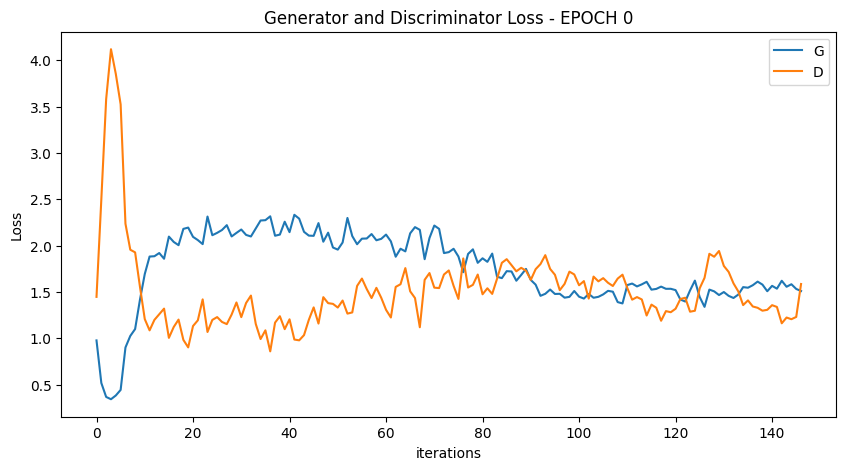

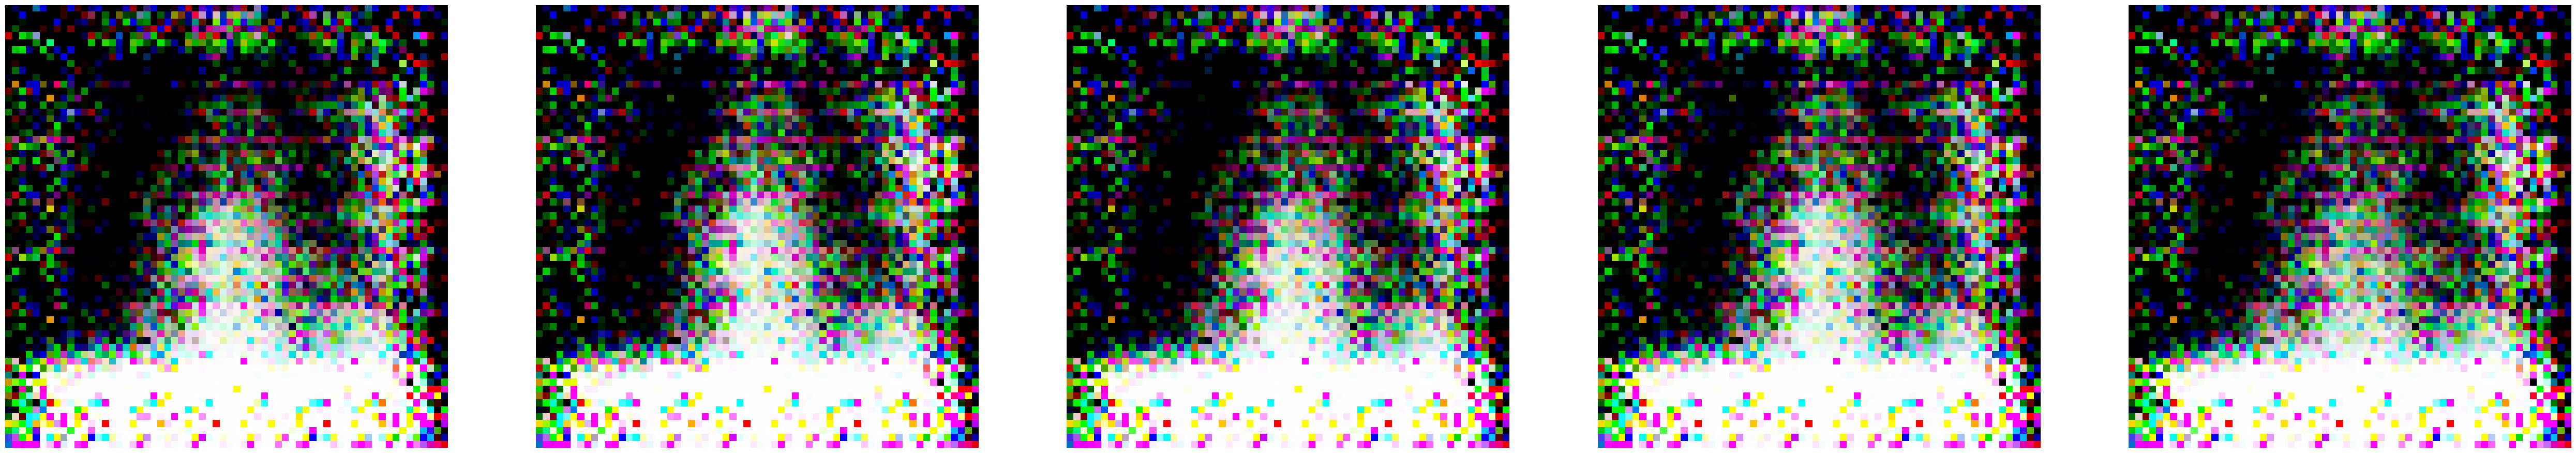

  0%|          | 0/147 [00:00<?, ?it/s]

[2/5][73/147] Loss_D: 1.5553 Loss_G: 0.8578 D(x): 0.4148 D(G(z)): 0.4767 / 0.4158
[2/5][146/147] Loss_D: 1.5037 Loss_G: 0.7844 D(x): 0.4380 D(G(z)): 0.5018 / 0.4471


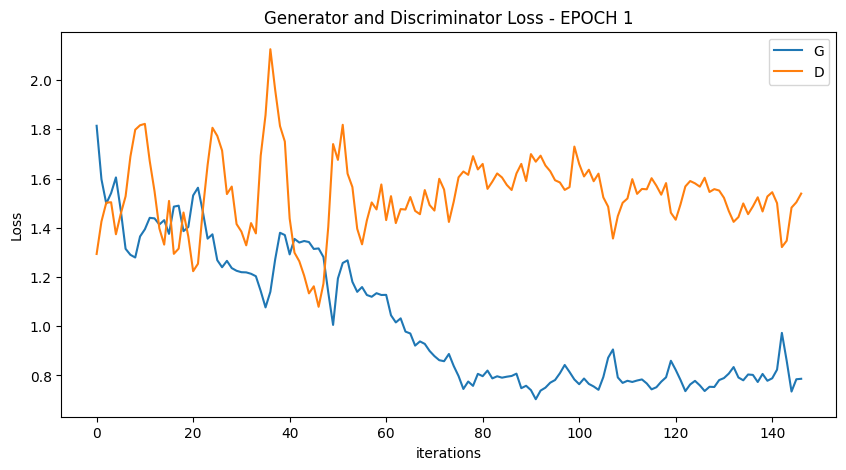

  0%|          | 0/147 [00:00<?, ?it/s]

[3/5][73/147] Loss_D: 1.4916 Loss_G: 0.7861 D(x): 0.4205 D(G(z)): 0.4725 / 0.4472
[3/5][146/147] Loss_D: 1.4823 Loss_G: 0.8475 D(x): 0.4358 D(G(z)): 0.4844 / 0.4166


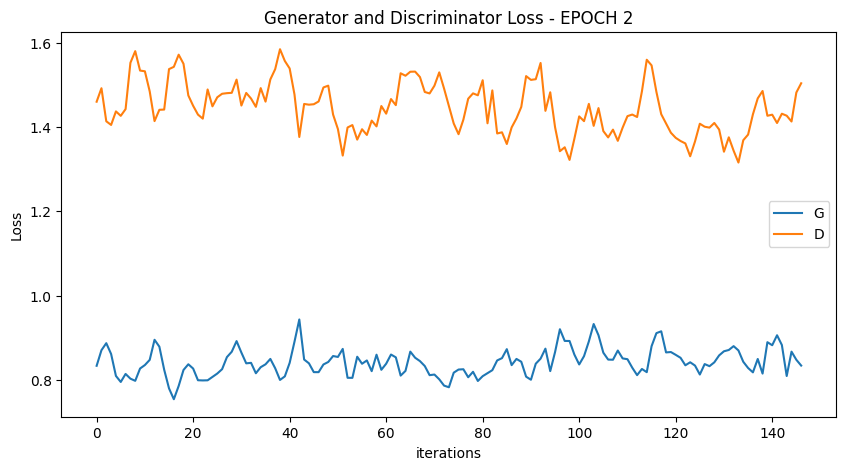

  0%|          | 0/147 [00:00<?, ?it/s]

[4/5][73/147] Loss_D: 1.4457 Loss_G: 0.7727 D(x): 0.4510 D(G(z)): 0.4816 / 0.4552
[4/5][146/147] Loss_D: 1.4319 Loss_G: 0.7996 D(x): 0.4304 D(G(z)): 0.4569 / 0.4397


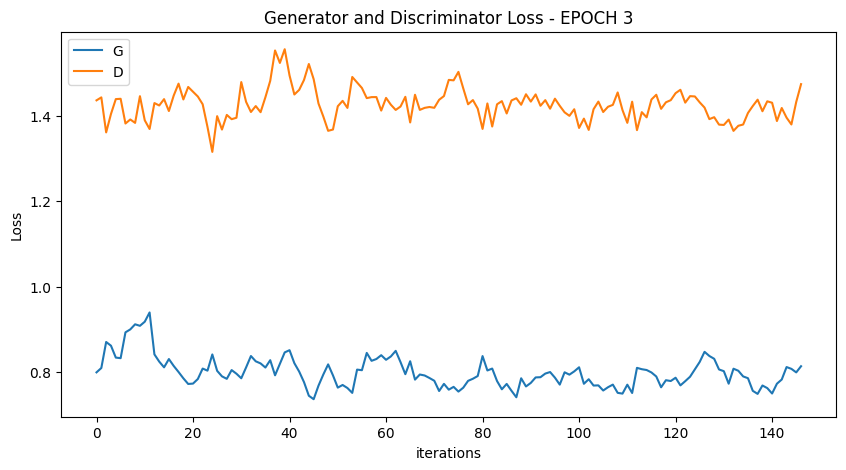

  0%|          | 0/147 [00:00<?, ?it/s]

[5/5][73/147] Loss_D: 1.3765 Loss_G: 0.8140 D(x): 0.4623 D(G(z)): 0.4597 / 0.4316
[5/5][146/147] Loss_D: 1.4029 Loss_G: 0.7701 D(x): 0.4496 D(G(z)): 0.4621 / 0.4559


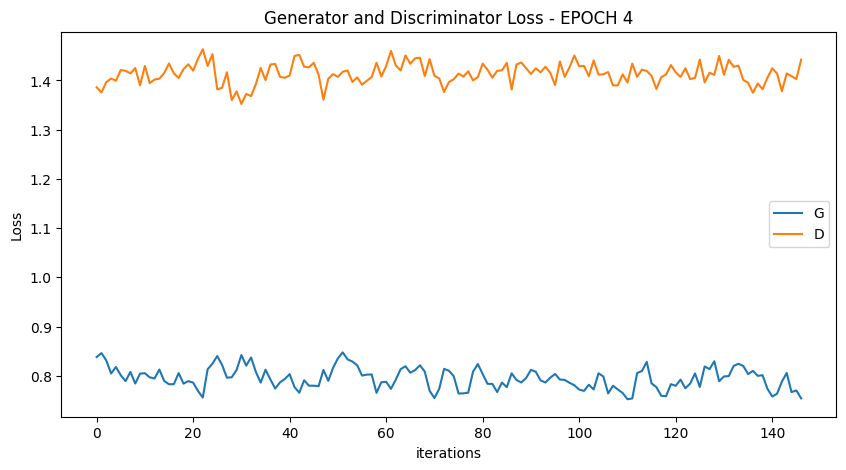

In [ ]:
for epoch in range(epochs):

    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)

#             valid_image = netG(fixed_noise)